# Reframing Design Pattern

In [1]:
import numpy as np
import seaborn as sns
from google.cloud import bigquery

import matplotlib as plt
%matplotlib inline

In [2]:
bq = bigquery.Client()

In [3]:
query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = 38
  AND mother_age = 28
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.01
"""

In [4]:
df = bq.query(query).to_dataframe()
df.head()

,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race
0,6.563162,True,38,28,1,1
1,7.098885,True,38,28,1,1
2,5.663676,True,38,28,1,1
3,8.062305,True,38,28,1,1
4,7.438397,True,38,28,1,1


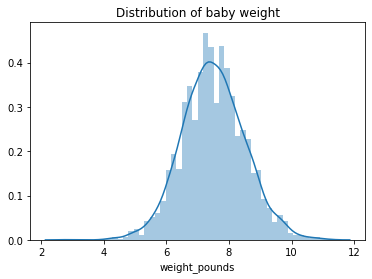

In [5]:
fig = sns.distplot(df[["weight_pounds"]])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")
fig.figure.savefig("weight_distrib.png")

In [6]:
#average weight_pounds for this cross section
np.mean(df.weight_pounds)

7.505303966970233

## Create categorical label

In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

In [2]:
df = pd.read_csv("./data/babyweight_train.csv")

In [3]:
# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

# create categorical label
def categorical_weight(weight_pounds):
    if weight_pounds < 3.31:
        return 0
    elif weight_pounds >= 3.31 and weight_pounds < 5.5:
        return 1
    elif weight_pounds >= 5.5 and weight_pounds < 8.8:
        return 2
    else:
        return 3

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x))

In [4]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,False,12,Single(1),40,1.0,2
1,7.561856,True,12,Single(1),40,2.0,2
2,7.187070,False,12,Single(1),34,3.0,2
3,6.375769,True,12,Single(1),36,2.0,2
4,7.936641,False,12,Single(1),35,0.0,2


In [5]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL_COLUMN = ['weight_category']

N_TRAIN = int(df.shape[0] * 0.80)

X_train, y_train = df[FEATURES][:N_TRAIN], encode_labels(df[LABEL_COLUMN][:N_TRAIN])
X_valid, y_valid = df[FEATURES][N_TRAIN:], encode_labels(df[LABEL_COLUMN][N_TRAIN:])

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid))

In [8]:
for dict_slice in train_data.take(1):
    print (dict_slice)

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>)


In [9]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

In [10]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# model
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)
output = layers.Dense(4, activation="softmax")(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])   

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


In [11]:
# train the model
model.fit(train_data.batch(50), epochs=1)

Train for 4234 steps
4234/4234 [==============================] - 19s 5ms/step - loss: 0.5733 - accuracy: 0.8417


In [21]:
val_loss, val_accuracy = model.evaluate(valid_data.batch(X_valid.shape[0]))
print("Validation accuracy: {}".format(val_accuracy))

1/1 [==============================] - 0s 317ms/step - loss: 0.8931 - accuracy: 0.6481
Validation accuracy: 0.6481394171714783


In [12]:
preds = model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                         "is_male": tf.convert_to_tensor(["True"]),
                         "mother_age": tf.convert_to_tensor([28]),
                         "mother_race": tf.convert_to_tensor(["1.0"]),
                         "plurality": tf.convert_to_tensor(["Single(1)"])},
                      steps=1).squeeze()
preds

array([9.0026711e-05, 1.9278120e-03, 5.3354180e-01, 4.6444038e-01],
      dtype=float32)

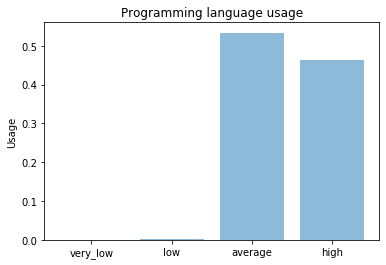

In [13]:
objects = ('very_low', 'low', 'average', 'high')
y_pos = np.arange(len(objects))
predictions = list(preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()

## Increasing the number of  categorical labels

We'll generalize the code above to accommodate `N` label buckets, instead of just 4. 

In [3]:
# Read in the data and preprocess
df = pd.read_csv("./data/babyweight_train.csv")

# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)
    
# create categorical label
MIN = np.min(df.weight_pounds)
MAX = np.max(df.weight_pounds)
NBUCKETS = 50

def categorical_weight(weight_pounds, weight_min, weight_max, nbuckets=10):
    buckets = np.linspace(weight_min, weight_max, nbuckets)
    
    return np.digitize(weight_pounds, buckets) - 1

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x, MIN, MAX, NBUCKETS))

In [4]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL_COLUMN = ['weight_category']

N_TRAIN = int(df.shape[0] * 0.80)

X_train, y_train = df[FEATURES][:N_TRAIN], encode_labels(df[LABEL_COLUMN][:N_TRAIN])
X_valid, y_valid = df[FEATURES][N_TRAIN:], encode_labels(df[LABEL_COLUMN][N_TRAIN:])

In [6]:
# create the training dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid))

Create the feature columns and build the model. 

In [7]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

In [8]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# model
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)
output = layers.Dense(NBUCKETS, activation="softmax")(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])  

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


In [9]:
# train the model
model.fit(train_data.batch(50), epochs=1)

Train for 4234 steps
4234/4234 [==============================] - 20s 5ms/step - loss: 2.6648 - accuracy: 0.1262


Make a prediction on the example above. 

In [10]:
preds = model.predict(x={"gestation_weeks": tf.convert_to_tensor([38]),
                         "is_male": tf.convert_to_tensor(["True"]),
                         "mother_age": tf.convert_to_tensor([28]),
                         "mother_race": tf.convert_to_tensor(["1.0"]),
                         "plurality": tf.convert_to_tensor(["Single(1)"])},
                      steps=1).squeeze()

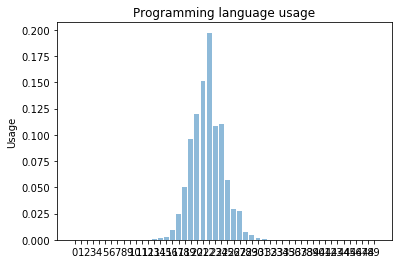

In [11]:
objects = [str(_) for _ in range(NBUCKETS)]
y_pos = np.arange(len(objects))
predictions = list(preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.show()